In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import librosa
from scipy.io import wavfile
import soundfile as sf

In [2]:
def get_spectrogram(filename):
    audio, sr = librosa.load(filename, sr = None)

    window_size = 2048  # Размер окна для STFT
    hop_length = int(window_size / 4)  
    n_fft = window_size


    spectrogram = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length, window=signal.hann(window_size))
    spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)


    # Plot the spectrogram
    plt.figure(figsize=(12, 5))
    librosa.display.specshow(spectrogram_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log') 
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram {filename}')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    return plt

C:\Users\Kokovino\AppData\Local\Temp\ipykernel_19508\1490193042.py:9: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  spectrogram = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length, window=signal.hann(window_size))


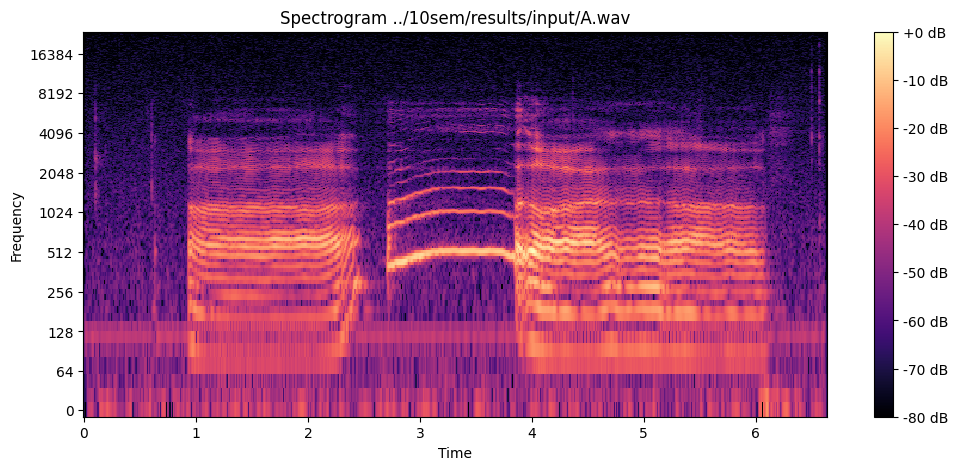

In [3]:
spectrogram_A = get_spectrogram('../10sem/results/input/A.wav')
spectrogram_A.savefig('../10sem/results/output/spectrogram_A.png')

C:\Users\Kokovino\AppData\Local\Temp\ipykernel_19508\1490193042.py:9: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  spectrogram = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length, window=signal.hann(window_size))


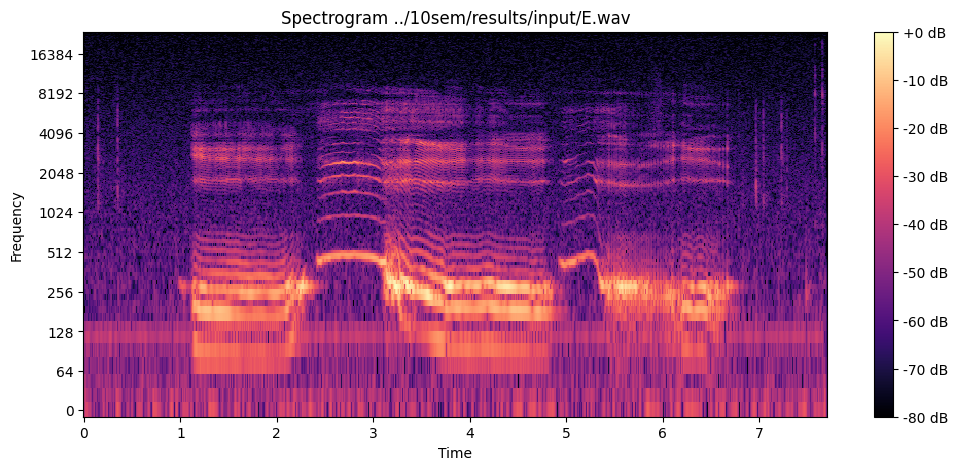

In [4]:
spectrogram_E = get_spectrogram('../10sem/results/input/E.wav')
spectrogram_E.savefig('../10sem/results/output/spectrogram_E.png')

C:\Users\Kokovino\AppData\Local\Temp\ipykernel_19508\1490193042.py:9: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  spectrogram = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length, window=signal.hann(window_size))


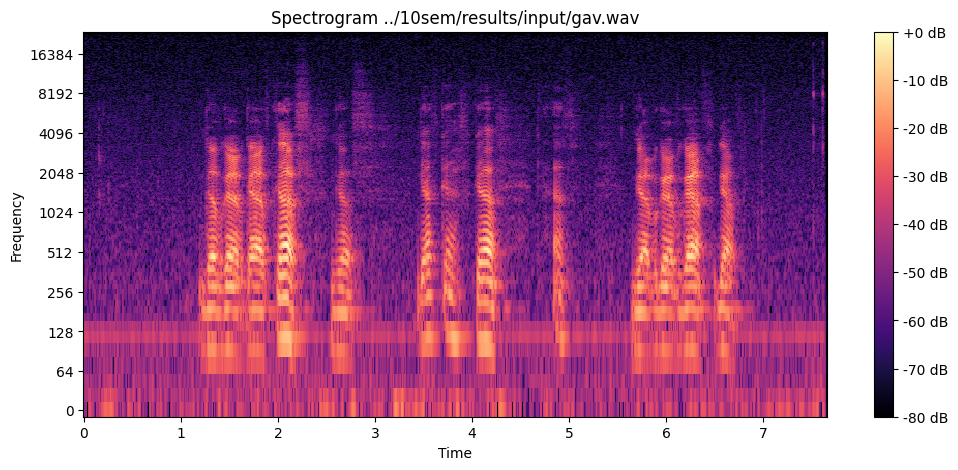

In [5]:
spectrogram_gav = get_spectrogram('../10sem/results/input/gav.wav')
spectrogram_gav.savefig('../10sem/results/output/spectrogram_gav.png')

In [6]:
def get_min_max_speech_freq(filename):
    audio_data, sample_rate = librosa.load(filename, sr=None, mono=True)
    frequencies = np.fft.rfftfreq(len(audio_data), d=1/sample_rate) #массив частот для результатов прямого быстрого преобразования фурье
    magnitudes = np.abs(np.fft.rfft(audio_data)) #модули амплитуд
    voice_frequencies = frequencies[np.where(magnitudes > np.mean(magnitudes))] # частоты, где амплитуды превышают среднее значение амплитуд
    min_voice_freq = np.min(voice_frequencies)
    max_voice_freq = np.max(voice_frequencies)
    return int(min_voice_freq), int(max_voice_freq)

In [7]:
min_voice_freq, max_voice_freq = get_min_max_speech_freq("../10sem/results/input/A.wav")
print('A')
print("Минимальная частота голоса:", int(min_voice_freq))
print("Максимальная частота голоса:", int(max_voice_freq))

A
Минимальная частота голоса: 0
Максимальная частота голоса: 6302


In [8]:
min_voice_freq, max_voice_freq = get_min_max_speech_freq("../10sem/results/input/E.wav")
print('E')
print("Минимальная частота голоса:", int(min_voice_freq))
print("Максимальная частота голоса:", int(max_voice_freq))

E
Минимальная частота голоса: 0
Максимальная частота голоса: 17578


In [9]:
min_voice_freq, max_voice_freq = get_min_max_speech_freq("../10sem/results/input/gav.wav")
print('Gav')
print("Минимальная частота голоса:", int(min_voice_freq))
print("Максимальная частота голоса:", int(max_voice_freq))

Gav
Минимальная частота голоса: 0
Максимальная частота голоса: 6865


In [10]:
def find_dominant_pitch_and_formants(filename, delta_t=0.1, delta_f=40):
    # Загрузка и параметры аудио
    audio, sr = librosa.load(filename, sr=None)
    n_fft = int(sr * delta_t)  # размер окна в сэмплах
    hop_length = n_fft // 4  # шаг окна

    # Получение спектрограммы
    stft_result = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    magnitudes = np.abs(stft_result)
    frequencies = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

    # Поиск доминирующего основного тона
    summed_magnitudes = np.sum(magnitudes, axis=1) #находит индекс с максимальной суммированной амплитудой(доминируюший тон)
    dominant_pitch_idx = np.argmax(summed_magnitudes) #частота для доминирующего
    dominant_pitch = frequencies[dominant_pitch_idx]

    # Поиск формант
    time_slices = magnitudes.shape[1]
    formants = []

    for i in range(time_slices): #Перебор по временным срезам спектрограммы для выявления трех сильнейших формант
        slice_magnitudes = magnitudes[:, i] #Извлекает вектор амплитуд для i-го временного среза
        max_idxs = np.argpartition(slice_magnitudes, -3)[-3:] # индексы трех наибольших элементов
        formant_freqs = frequencies[max_idxs] #извлекаем частоты и амиплитуды этих частот 
        formant_powers = slice_magnitudes[max_idxs]
        sorted_idxs = np.argsort(-formant_powers) #по убыванию
        formants.append(formant_freqs[sorted_idxs])

    # Усреднение найденных формант по времени
    avg_formants = np.mean(formants, axis=0)
    
    return dominant_pitch, avg_formants

In [11]:
dominant_pitch_A, formants_A = find_dominant_pitch_and_formants('../10sem/results/input/A.wav')
print('A')
print("Доминирующий основной тон:", dominant_pitch_A)
print("Три самые сильные форманты:", formants_A)

A
Доминирующий основной тон: 520.0
Три самые сильные форманты: [420.78947368 428.83458647 433.23308271]


In [12]:
dominant_pitch_E, formants_E = find_dominant_pitch_and_formants('../10sem/results/input/E.wav')
print('E')
print("Доминирующий основной тон:", dominant_pitch_E)
print("Три самые сильные форманты:", formants_E)


E
Доминирующий основной тон: 280.0
Три самые сильные форманты: [246.14886731 258.67313916 300.84142395]


In [13]:
dominant_pitch_gav, formants_gav = find_dominant_pitch_and_formants('../10sem/results/input/gav.wav')
print('Gav')
print("Доминирующий основной тон:", dominant_pitch_gav)
print("Три самые сильные форманты:", formants_gav)

Gav
Доминирующий основной тон: 470.0
Три самые сильные форманты: [188.85993485 190.42345277 212.54071661]
